# Setup 

In [ ]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -p tensorflow,numpy -m

tensorflow 1.12.0
numpy 1.14.6

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.14.65+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [ ]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Data


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

4423680/4422102 [==============================] - 0s 0us/step


Value distribution of X:

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.Series(x_train.reshape(-1)).describe()

count   47040000.000
mean          72.940
std           90.021
min            0.000
25%            0.000
50%            0.000
75%          163.000
max          255.000
dtype: float64

Value distribution of Y:


In [ ]:
pd.Series(y_train.reshape(-1)).describe()

count   60000.000
mean        4.500
std         2.872
min         0.000
25%         2.000
50%         4.500
75%         7.000
max         9.000
dtype: float64

### Validation set

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=1/6)
train_index, valid_index = next(sss.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape, x_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


# Model

Standard Convolutional Neural Network: 3 layers with drop-out and batch normalization between each layer.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
__________

# Training



In [ ]:
model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
%%time
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

model.fit_generator(
    train_gen(512),
    epochs=15,
    steps_per_epoch=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/15
100/100 [==============================] - 18s 184ms/step - loss: 1.0343 - sparse_categorical_accuracy: 0.7166 - val_loss: 1.3659 - val_sparse_categorical_accuracy: 0.6235
Epoch 2/15
100/100 [==============================] - 13s 130ms/step - loss: 0.4910 - sparse_categorical_accuracy: 0.8329 - val_loss: 1.3595 - val_sparse_categorical_accuracy: 0.6332
Epoch 3/15
100/100 [==============================] - 13s 130ms/step - loss: 0.3998 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.8123
Epoch 4/15
100/100 [==============================] - 13s 130ms/step - loss: 0.3440 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.3880 - val_sparse_categorical_accuracy: 0.8589
Epoch 5/15
100/100 [==============================] - 13s 130ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.2717 - val_sparse_categorical_accuracy: 0.9011
Epoch 6/15
100/100 [==============================] - 13s 131ms/step - loss: 0.2842 -

# Testing

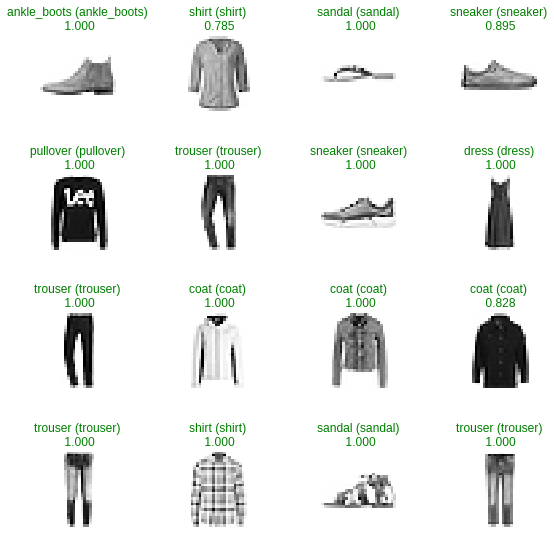

In [ ]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, true_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  fig = pyplot.figure(figsize=(4,3))
  # axes = fig.add_subplot(nc, 4)
  f, axes = pyplot.subplots(nc, 4)
  f.tight_layout()
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    pred_label = np.argmax(predictions[i])
    axes[x, y].set_title("{} ({})\n {:.3f}".format(
      LABEL_NAMES[pred_label], 
      LABEL_NAMES[true_labels[i]],
      confidence
    ), color=("green" if true_labels[i] == pred_label else "red"))
  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(
    np.squeeze(x_test[:16]), 
    model.predict(x_test[:16]),
    y_test[:16]
)

In [ ]:
%%time
# Evaluate the model on valid set
score = model.evaluate(x_valid, y_valid, verbose=0)

# Print test accuracy
print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.9252
CPU times: user 1.25 s, sys: 208 ms, total: 1.46 s
Wall time: 1.93 s


In [ ]:
%%time
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9204
CPU times: user 1.27 s, sys: 183 ms, total: 1.46 s
Wall time: 1.82 s
